In [ ]:
!pip install folium mlxtend branca

In [ ]:
import pandas as pd
import numpy as np
import folium
import random
import time
from datetime import datetime, timedelta

from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from mlxtend.frequent_patterns import apriori, association_rules
from folium.plugins import MarkerCluster, TimestampedGeoJson, HeatMap

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

Campus Coordinates

In [ ]:
# Campus center point
campus_center = [23.8295, 90.5663]

# Important locations (coordinates)
location_coords = {
    'Library': [23.8295, 90.5663],
    'Cafeteria': [23.8290, 90.5668],
    'Main Gate': [23.8287, 90.5662],
    'Auditorium': [23.8292, 90.5657],
    'Administrative Building': [23.8298, 90.5665],
    'Computer Lab': [23.8296, 90.5659],
    'Playground': [23.8300, 90.5660],
    'Parking Lot': [23.8289, 90.5658],
    'Admin Office': [23.8299, 90.5666],
    'Garden Area': [23.8302, 90.5664],
    'Gymnasium': [23.8301, 90.5661],
    'Lecture Hall A': [23.8293, 90.5667],
    'Lecture Hall B': [23.8291, 90.5669],
    'Main Library': [23.8294, 90.5662],
    'Medical Center': [23.8297, 90.5660],
    'Parking Area': [23.8288, 90.5663],
    'Student Lounge': [23.8290, 90.5659]
}


Loading Dataset

In [ ]:
df = pd.read_csv('/content/smart_campus_data.csv')

# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

# Preview data
print("")
display(df.head())

# Rename columns to fit expected structure
df.rename(columns={
    'Location_Name': 'Location',
    'Event': 'Activity'
}, inplace=True)

# Validate required columns
expected_columns = {'Location', 'Timestamp', 'Activity'}
missing_cols = expected_columns - set(df.columns)
if missing_cols:
    raise ValueError(f"❌ Missing required columns: {missing_cols}")

,Student_ID,Location_Name,Building_Name,Floor,X_Coordinate,Y_Coordinate,Foot_Traffic_Density,Timestamp,Event
0,1,Main Library,Main Gate,2,92.04,59.21,High,2025-05-16 14:04:00,NaN
1,2,Student Lounge,Cultural Hall,3,17.48,77.17,High,2025-05-16 08:32:00,Orientation
2,3,Student Lounge,Student Center,3,90.25,97.25,Low,2025-05-16 17:22:00,NaN
3,4,Cafeteria,Engineering Block,3,86.38,49.86,Low,2025-05-16 14:21:00,Sports Event
4,5,Garden Area,Student Center,2,37.64,75.63,High,2025-05-16 11:12:00,Orientation


Convert Timestamp

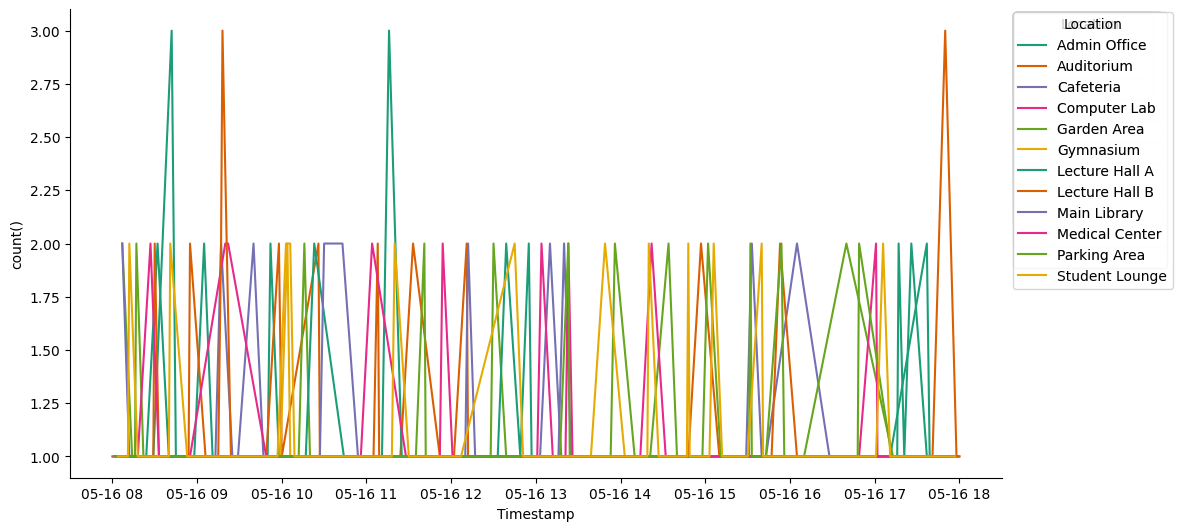

In [ ]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Timestamp']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Timestamp'}, axis=1)
              .sort_values('Timestamp', ascending=True))
  xs = counted['Timestamp']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Timestamp', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Location')):
  _plot_series(series, series_name, i)
  fig.legend(title='Location', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Timestamp')
_ = plt.ylabel('count()')

Crowd Density

In [ ]:
# Ensure Timestamp is in datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

# Extract Date for daily density
df['Date'] = df['Timestamp'].dt.date

# Compute Density: number of records per location per day
density_df = df.groupby(['Date', 'Location']).size().reset_index(name='Density')

# Merge density back into main dataframe
df = pd.merge(df, density_df, on=['Date', 'Location'], how='left')

# Create Density Map (reusing existing location_coords)

fmap = folium.Map(location=[23.7806, 90.4070], zoom_start=17)
marker_cluster = MarkerCluster().add_to(fmap)

def get_density_color(d):
    if d >= 80:
        return 'red'
    elif d >= 50:
        return 'orange'
    elif d >= 20:
        return 'green'
    else:
        return 'blue'

# Drop duplicates to avoid double-plotting same location/date
for _, row in df.drop_duplicates(subset=['Date', 'Location']).iterrows():
    loc_name = row['Location']
    coords = location_coords.get(loc_name)

    if coords:
        folium.CircleMarker(
            location=coords,
            radius=7,
            color=get_density_color(row['Density']),
            fill=True,
            fill_opacity=0.8,
            popup=f"<b>{loc_name}</b><br>Date: {row['Date']}<br>Density: {row['Density']}"
        ).add_to(marker_cluster)

fmap


Student Movement Clustering (KMeans)

In [ ]:
# location mapping
location_mapping = {loc: idx for idx, loc in enumerate(df['Location'].unique())}

df['LocationCode'] = df['Location'].map(location_mapping)

if df['LocationCode'].isnull().any():
    print("Warning: NaN values found in LocationCode. Dropping rows with missing LocationCode.")
    # Drop rows where 'LocationCode' is NaN
    df_cleaned_movement = df.dropna(subset=['LocationCode']).copy()
else:
    df_cleaned_movement = df.copy()

# Select the cleaned data for clustering
movement_data = df_cleaned_movement[['LocationCode']]

movement_data = movement_data.astype(float) # Convert to float

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_cleaned_movement['Cluster'] = kmeans.fit_predict(movement_data)

df = df_cleaned_movement

df.head()

,Student_ID,Location,Building_Name,Floor,X_Coordinate,Y_Coordinate,Foot_Traffic_Density,Timestamp,Activity,Date,Density,LocationCode,Cluster
0,1,Main Library,Main Gate,2,92.04,59.21,High,2025-05-16 14:04:00,NaN,2025-05-16,79,0,1
1,2,Student Lounge,Cultural Hall,3,17.48,77.17,High,2025-05-16 08:32:00,Orientation,2025-05-16,98,1,1
2,3,Student Lounge,Student Center,3,90.25,97.25,Low,2025-05-16 17:22:00,NaN,2025-05-16,98,1,1
3,4,Cafeteria,Engineering Block,3,86.38,49.86,Low,2025-05-16 14:21:00,Sports Event,2025-05-16,74,2,1
4,5,Garden Area,Student Center,2,37.64,75.63,High,2025-05-16 11:12:00,Orientation,2025-05-16,78,3,1


Decision Tree

              precision    recall  f1-score   support

 Class Break       0.25      0.15      0.19        20
  Lunch Time       0.20      0.06      0.10        31
 Orientation       0.18      0.79      0.29        24
     Seminar       0.00      0.00      0.00        28
Sports Event       0.00      0.00      0.00        26

    accuracy                           0.19       129
   macro avg       0.13      0.20      0.12       129
weighted avg       0.12      0.19      0.11       129

Precision: 0.120, Recall: 0.186, F1-score: 0.106


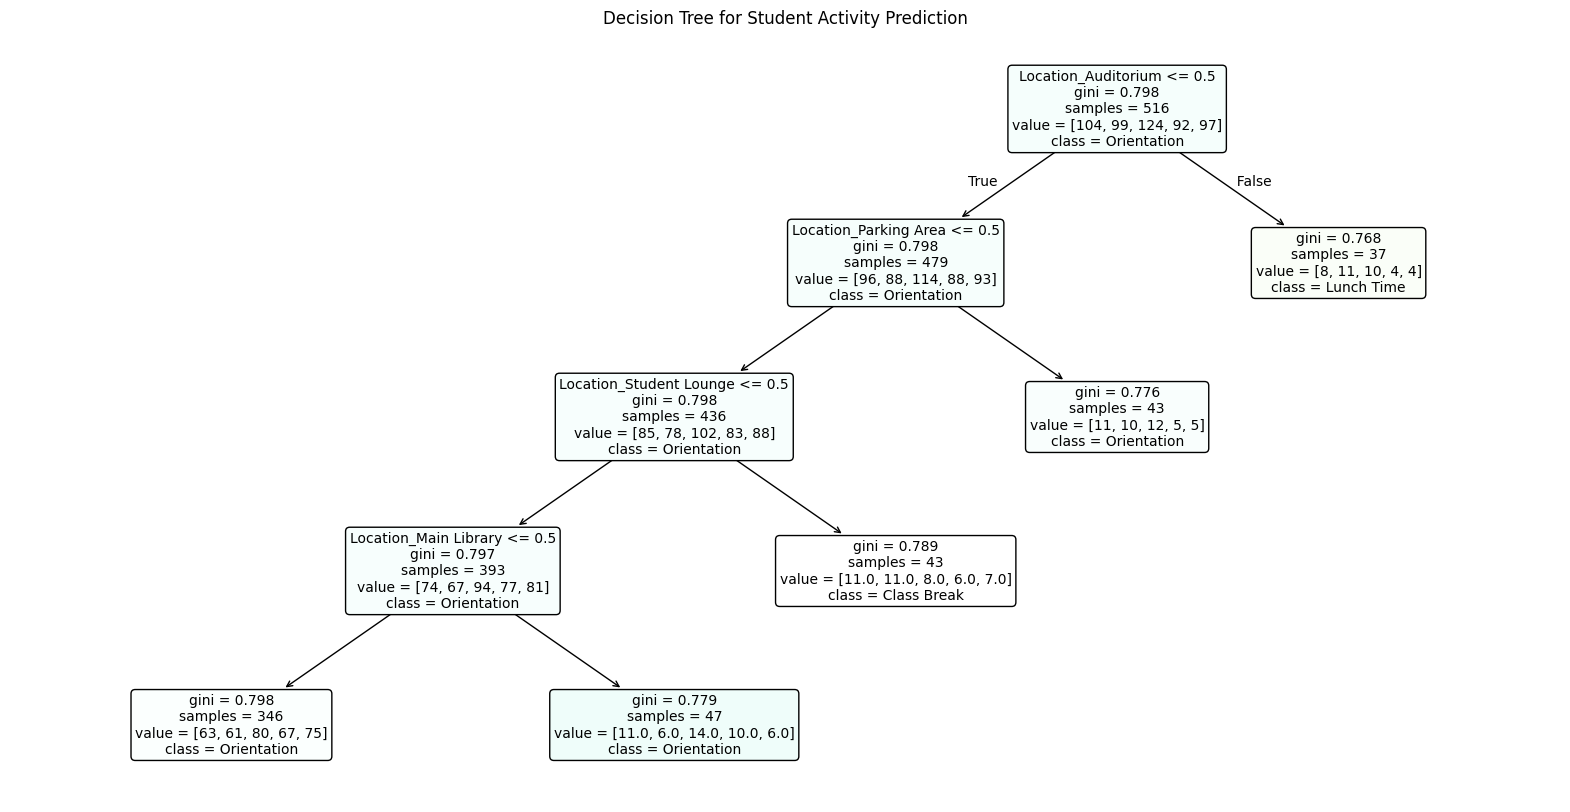

In [ ]:
df_cleaned_tree = df.dropna(subset=['Activity']).copy()

# One-hot encode 'Location' features and set 'Activity' as target
X = pd.get_dummies(df_cleaned_tree[['Location']])
y = df_cleaned_tree['Activity']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Print classification report with zero_division=0 to suppress warnings
print(classification_report(y_test, y_pred, zero_division=0))

# Calculate and print precision, recall, and f1-score separately
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}")

# Visualize the Decision Tree
plt.figure(figsize=(20,10))
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=clf.classes_,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree for Student Activity Prediction")
plt.show()

Map Centered Around Campus

In [ ]:
building_map = folium.Map(location=campus_center, zoom_start=18)

# Add Building Markers and Labels
for name, coords in location_coords.items():
    # Marker
    folium.Marker(
        location=coords,
        icon=folium.Icon(color='red', icon='info-sign'),
        popup=name
    ).add_to(building_map)

    # Slightly offset Label
    folium.map.Marker(
        location=[coords[0] + 0.00015, coords[1] + 0.00015],
        icon=folium.DivIcon(
            html=f"""<div style="font-size: 12px; color: black;"><b>{name}</b></div>"""
        )
    ).add_to(building_map)

# Display the map
building_map

Heatmap Layer

In [ ]:
campus_map = folium.Map(location=campus_center, zoom_start=17)

# Generate random heat points near the campus center
students = []
for _ in range(500):
    lat = campus_center[0] + random.uniform(-0.002, 0.002)
    lon = campus_center[1] + random.uniform(-0.002, 0.002)
    students.append([lat, lon])

# Add Heatmap layer
HeatMap(students, radius=15, blur=20, max_zoom=1).add_to(campus_map)

campus_map

Add Markers and Labels

In [ ]:
for name, coords in location_coords.items():
    # Marker
    folium.Marker(
        location=coords,
        icon=folium.Icon(color='red', icon='info-sign'),
        popup=name
    ).add_to(campus_map)

    # Slightly offset Label
    folium.map.Marker(
        location=[coords[0] + 0.00015, coords[1] + 0.00015],
        icon=folium.DivIcon(
            html=f"""<div style="font-size: 12px; color: black;"><b>{name}</b></div>"""
        )
    ).add_to(campus_map)

campus_map

Simulate Movement

In [ ]:
# Simulate moving students
moving_students = []
for _ in range(10):
    start_loc = random.choice(list(location_coords.values()))
    movement = []
    for t in range(5):
        lat = start_loc[0] + random.uniform(-0.0002, 0.0002)
        lon = start_loc[1] + random.uniform(-0.0002, 0.0002)
        time_stamp = (datetime.now() + timedelta(seconds=t*10)).isoformat()
        movement.append({
            'coordinates': [lon, lat],
            'time': time_stamp
        })
    moving_students.append(movement)

# Create GeoJson features
features = []
for path in moving_students:
    feature = {
        'type': 'Feature',
        'geometry': {'type': 'LineString', 'coordinates': [p['coordinates'] for p in path]},
        'properties': {
            'times': [p['time'] for p in path],
            'style': {'color': random.choice(['red', 'blue', 'green', 'purple'])}
        }
    }
    features.append(feature)

# Add Timestamped Animation
TimestampedGeoJson(
    {'type': 'FeatureCollection', 'features': features},
    period='PT10S',
    add_last_point=True,
    auto_play=True,
    loop=True
).add_to(campus_map)

# Final Map with everything
campus_map

Most Popular Location Ranking

In [ ]:
top_locations = df['Location'].value_counts().head(3).reset_index()
top_locations.columns = ['Location', 'Count']
print("Top 3 Most Visited Locations:")
print(top_locations.to_string(index=False))

Top 3 Most Visited Locations:
      Location  Count
Lecture Hall B    100
Student Lounge     98
Lecture Hall A     97


Peak Time Analysis per Location

In [ ]:
df['Hour'] = df['Timestamp'].dt.hour
peak_hours = df.groupby('Location')['Hour'].agg(lambda x: x.mode()[0] if not x.mode().empty else 'No data')
print("Peak visiting hour for each location:")
print(peak_hours.to_string(index=True, header=False))

Peak visiting hour for each location:
Admin Office       9
Auditorium         8
Cafeteria          9
Computer Lab      14
Garden Area       13
Gymnasium         10
Lecture Hall A    14
Lecture Hall B     9
Main Library      10
Medical Center    13
Parking Area      15
Student Lounge     8


Activity Prediction Accuracy Report

In [ ]:
# Activity Prediction Accuracy with Cross-Validation
df_cleaned = df.dropna(subset=['Activity']).copy()

X = pd.get_dummies(df_cleaned[['Location']])
y = df_cleaned['Activity']

clf = DecisionTreeClassifier()
scores = cross_val_score(clf, X, y, cv=5, error_score='raise')

print("Cross-Validation Accuracy Scores:", scores)
print("Mean Accuracy:", scores.mean())

Cross-Validation Accuracy Scores: [0.1627907  0.24031008 0.18604651 0.24031008 0.18604651]
Mean Accuracy: 0.20310077519379846


Overcrowding Alert

In [ ]:
# Function to check for overcrowding based on a threshold
def check_overcrowding(df, location_coords, time_window='1h', threshold=10):

    # Group by location and resample by time window, then count unique students
    overcrowding_counts = df.groupby('Location').resample(time_window, on='Timestamp')['Student_ID'].nunique().reset_index()

    # Filter for locations and time windows where the count exceeds the threshold
    potential_overcrowding = overcrowding_counts[overcrowding_counts['Student_ID'] > threshold].copy()

    # Add coordinates to the overcrowding alerts
    potential_overcrowding['Latitude'] = potential_overcrowding['Location'].apply(lambda x: location_coords.get(x, [None, None])[0])
    potential_overcrowding['Longitude'] = potential_overcrowding['Location'].apply(lambda x: location_coords.get(x, [None, None])[1])

    # Drop rows where coordinates couldn't be found
    potential_overcrowding.dropna(subset=['Latitude', 'Longitude'], inplace=True)

    return potential_overcrowding

# Check for overcrowding every hour with a threshold
overcrowding_alerts = check_overcrowding(df, location_coords, time_window='1h', threshold=10)

print("\n🚨 Potential Overcrowding Alerts:")
print(overcrowding_alerts)


if not overcrowding_alerts.empty:
    overcrowding_map = folium.Map(location=campus_center, zoom_start=17)

    for _, row in overcrowding_alerts.iterrows():
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=10,
            color='darkred',
            fill=True,
            fill_opacity=0.8,
            popup=f"<b>Overcrowding Alert</b><br>"
                  f"Location: {row['Location']}<br>"
                  f"Time: {row['Timestamp']}<br>"
                  f"Students Count: {row['Student_ID']}"
        ).add_to(overcrowding_map)

    # Display the overcrowding map
    print("")
    display(overcrowding_map)
else:
    print("\n✅ No overcrowding alerts detected based on the current threshold and time window.")


🚨 Potential Overcrowding Alerts:
           Location           Timestamp  Student_ID  Latitude  Longitude
1      Admin Office 2025-05-16 09:00:00          12   23.8299    90.5666
10       Auditorium 2025-05-16 08:00:00          11   23.8292    90.5657
21        Cafeteria 2025-05-16 09:00:00          13   23.8290    90.5668
27        Cafeteria 2025-05-16 15:00:00          11   23.8290    90.5668
36     Computer Lab 2025-05-16 14:00:00          13   23.8296    90.5659
40      Garden Area 2025-05-16 08:00:00          11   23.8302    90.5664
45      Garden Area 2025-05-16 13:00:00          14   23.8302    90.5664
53        Gymnasium 2025-05-16 10:00:00          12   23.8301    90.5661
62   Lecture Hall A 2025-05-16 08:00:00          11   23.8293    90.5667
68   Lecture Hall A 2025-05-16 14:00:00          15   23.8293    90.5667
70   Lecture Hall A 2025-05-16 16:00:00          14   23.8293    90.5667
71   Lecture Hall A 2025-05-16 17:00:00          13   23.8293    90.5667
72   Lecture Hall